In [1]:
# Add word2vec to python path.
import sys
sys.path.append("external/word2vec")

In [2]:
# Data Processing.
import json
import pandas as pd

# PyTorch.
import torch
from torch.utils.data import Dataset
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Word2Vec.
from external.word2vec.train import train
from external.word2vec.utils.helper import (
    get_model_class,
    get_optimizer_class,
    get_lr_scheduler,
    save_vocab,
    load_vocab,
)

# Plotting.
import matplotlib.pyplot as plt

/home/fangj/ttvp/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check CUDA availability.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Load Config
config = {
    "use_cuda": True,
    
    "model_name": "skipgram",
    "data_dir": "data/",
    "data_size": -1,
    "model_dir": "models/skipgram/",
    "pre_trained_model_path": "external/word2vec/models/skipgram_blog/best_val_model_5.67.pt",
    "pre_trained_vocab_path": "external/word2vec/models/skipgram_blog/vocab.pt",
    "vocab_min_word_freq": 5,
    
    "train_batch_size": 128,
    "val_batch_size": 128,
    "shuffle": True,
    
    "optimizer": "Adam",
    "learning_rate": 0.025,
    "epochs": 64,
    "train_steps": -1,
    "val_steps": -1,
    
    "checkpoint_frequency": 4,
}

# Load Data

In [5]:
videoDf = pd.read_csv("data/USvideos.csv")
videoDf.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [6]:
# Dataset for twitter financial news text.
class YouTubeTitleDataset(Dataset):
    def __init__(self, df: pd.DataFrame, size = -1):
        self.titleDf = df
        # Shuffle and take a subset of the data.
        if size > 0:
            self.titleDf = self.titleDf.sample(frac=1).reset_index(drop=True)
            self.titleDf = self.titleDf[:size]
        
    def __len__(self):
        return len(self.titleDf)
    
    def __getitem__(self, idx):
        return self.titleDf["title"][idx]
    
    def __iter__(self):
        for title in self.titleDf["title"]:
            yield title

In [7]:
# Create title dataset.
titleDataset = YouTubeTitleDataset(videoDf, size = config["data_size"])

# Load Vocab

In [8]:
if (config["pre_trained_vocab_path"]):
    vocab: Vocab = load_vocab(config["pre_trained_vocab_path"])
    vocabSize = len(vocab.get_stoi())
    print(f"Pretrained vocab size: {vocabSize}")
else:
    vocab = None

Pretrained vocab size: 6630


In [9]:
# Get the english tokenizer.
tokenizer = get_tokenizer("basic_english", language="en")
# Build the extended vocab based on dataset.
extendVocab = build_vocab_from_iterator(
    map(tokenizer, titleDataset),
    min_freq=config["vocab_min_word_freq"],
)
len(extendVocab)

8357

In [10]:
newTokens = []
for word in extendVocab.get_stoi():
    if not word in vocab:
        newTokens.append(word)
# Add all new tokens to the vocab.
for token in newTokens:
    vocab.append_token(token)
print(f"{len(newTokens)} new tokens added to the vocab.")
vocabSize = len(vocab.get_stoi())
print(f"Extended vocab size: {vocabSize}")

4981 new tokens added to the vocab.
Extended vocab size: 11611


# Transfer Learning

In [11]:
pretrainedModel = torch.load(config["pre_trained_model_path"], map_location=torch.device("cpu"))

In [12]:
train(
    config=config,
    data_iter=titleDataset,
    vocab=vocab,
    transfer_model = pretrainedModel,
)

Using device: cuda
Vocabulary size: 11611
Adjusting learning rate of group 0 to 2.5000e-02.
Transfer learning enabled. Pre-trained model loaded.
Epoch: 1/64, Train Loss=6.26778, Val Loss=5.37265
Time elapsed: 0.14 min, average epoch time: 0.14 min, predicting finish time: 8.93 min
Adjusting learning rate of group 0 to 2.4609e-02.
Epoch: 2/64, Train Loss=5.21237, Val Loss=5.19961
Time elapsed: 0.27 min, average epoch time: 0.14 min, predicting finish time: 8.70 min
Adjusting learning rate of group 0 to 2.4219e-02.
Epoch: 3/64, Train Loss=5.11114, Val Loss=5.17323
Time elapsed: 0.40 min, average epoch time: 0.13 min, predicting finish time: 8.61 min
Adjusting learning rate of group 0 to 2.3828e-02.
Epoch: 4/64, Train Loss=5.08783, Val Loss=5.11335
Time elapsed: 0.53 min, average epoch time: 0.13 min, predicting finish time: 8.47 min
Adjusting learning rate of group 0 to 2.3438e-02.
Epoch: 5/64, Train Loss=5.05163, Val Loss=5.11400
Time elapsed: 0.65 min, average epoch time: 0.13 min, pre

# Plot Loss

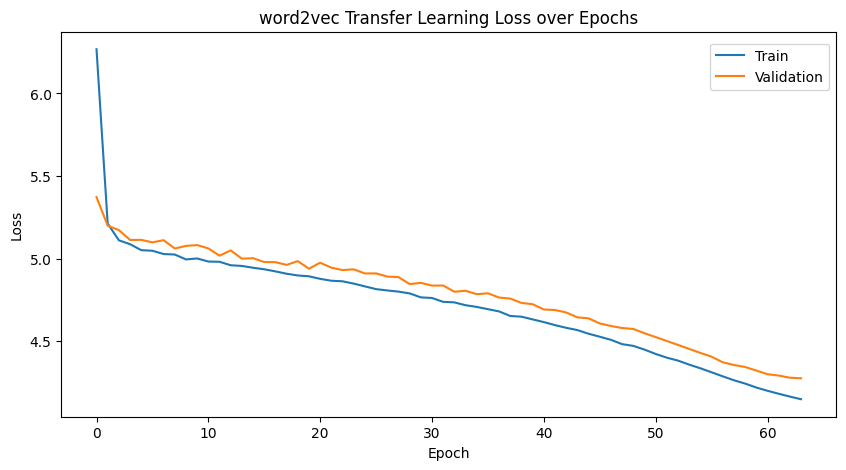

In [27]:
# Plot the loss.
with open(config["model_dir"] + "loss.json", "r") as f:
    loss = json.load(f)

# Create a figure.
ax = plt.figure(figsize=(10, 5))
# Add title.
plt.title("word2vec Transfer Learning Loss over Epochs")
# Add x-axis label.
plt.xlabel("Epoch")
# Add y-axis label.
plt.ylabel("Loss")
# Plot the loss.
plt.plot(loss["train"], label="Train")
plt.plot(loss["val"], label="Validation")
# Add legend inside the plot.
ax.legend(loc="upper right", bbox_to_anchor=(0.9, 0.87), bbox_transform=ax.transFigure)